In [85]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import numpy as np

In [86]:
# 1. Load Dataset
data = pd.read_csv('new_lung_cancer.csv')

In [87]:
# Preview the dataset
print("Dataset Head:\n", data.head())

Dataset Head:
   GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   78        2               2        1              1   
1      F   55        2               1        1              2   
2      F   54        1               2        2              1   
3      F   18        1               1        1              1   
4      F   47        1               2        2              2   

   CHRONIC_DISEASE  FATIGUE  ALLERGY  WHEEZING  ...  SWALLOWING_DIFFICULTY  \
0                2        1        1         1  ...                      1   
1                1        1        2         1  ...                      2   
2                2        1        1         2  ...                      1   
3                1        2        1         1  ...                      1   
4                1        2        1         2  ...                      2   

   CHEST_PAIN  EXERCISE_FREQUENCY  DIET_QUALITY  FAMILY_HISTORY  \
0           2                   2             3     

In [88]:
# Check for missing values
print("Missing Values:\n", data.isnull().sum())

Missing Values:
 GENDER                    0
AGE                       0
SMOKING                   0
YELLOW_FINGERS            0
ANXIETY                   0
PEER_PRESSURE             0
CHRONIC_DISEASE           0
FATIGUE                   0
ALLERGY                   0
WHEEZING                  0
ALCOHOL_CONSUMING         0
COUGHING                  0
SHORTNESS_OF_BREATH       0
SWALLOWING_DIFFICULTY     0
CHEST_PAIN                0
EXERCISE_FREQUENCY        0
DIET_QUALITY              0
FAMILY_HISTORY            0
OCCUPATIONAL_HAZARD       0
ENVIRONMENTAL_EXPOSURE    0
BMI                       0
SLEEP_HOURS               0
LUNG_CANCER               0
dtype: int64


In [89]:
# Check for non-numeric columns
non_numeric_cols = data.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index(['GENDER', 'LUNG_CANCER'], dtype='object')


In [90]:
# Convert non-numeric columns to numeric (Label Encoding for simplicity)
for col in non_numeric_cols:
    data[col] = data[col].astype('category').cat.codes

In [91]:
# Separate features and target
X = data.drop(columns=["GENDER"])  # Replace "target" with the actual label column
y = data["GENDER"]

In [92]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert ['NO', 'YES'] to [0, 1]


In [93]:
# Fill missing values in numeric columns with the mean
X.fillna(X.mean(), inplace=True)

In [94]:
# Encode categorical variables (if any)
X = pd.get_dummies(X, drop_first=True)

In [95]:
# Standardize the dataset
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

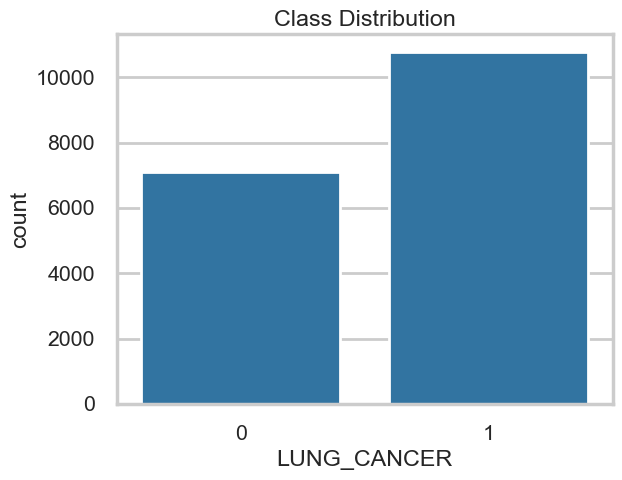

In [96]:
sns.countplot(x='LUNG_CANCER', data=data)
plt.title("Class Distribution")
plt.show()

In [97]:
print(data['LUNG_CANCER'].value_counts(normalize=True) * 100)

LUNG_CANCER
1    60.31906
0    39.68094
Name: proportion, dtype: float64


In [98]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical columns
encoder = LabelEncoder()
X['GENDER'] = encoder.fit_transform(X['GENDER'])  # Encode GENDER as 0 and 1
y = encoder.fit_transform(y)  # Encode LUNG_CANCER as 0 (NO) and 1 (YES)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class distribution after resampling
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))  # Output: {0: <count>, 1: <count>}

{0: 10776, 1: 10776}


In [99]:
print("Class Distribution After SMOTE:")
print(pd.Series(y_resampled).value_counts(normalize=True) * 100)

Class Distribution After SMOTE:
0    50.0
1    50.0
Name: proportion, dtype: float64


In [100]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [101]:
# Define number of features
n_features = X_train.shape[1]

In [102]:
# 2. Genetic Algorithm for Feature Selection
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_features(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if len(selected_features) == 0:
        return 0,
    X_train_selected = X_train[:, selected_features]
    rf = RandomForestClassifier()
    scores = cross_val_score(rf, X_train_selected, y_train, cv=5, scoring='accuracy')
    return scores.mean(),

toolbox.register("evaluate", eval_features)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [103]:
# Genetic Algorithm Parameters
population = toolbox.population(n=50)
generations = 20

gahof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("mean", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Create a logbook to store fitness statistics for each generation
logbook = tools.Logbook()
logbook.header = ["gen", "nevals"] + stats.fields

algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=generations, 
                    stats=stats, halloffame=gahof, verbose=True)


gen	nevals	mean    	std    	min     	max
0  	50    	0.775123	0.22518	0.528618	1  
1  	26    	0.965474	0.117124	0.558284	1  
2  	24    	1       	0       	1       	1  
3  	27    	0.991087	0.0623889	0.554365	1  
4  	34    	1       	0        	1       	1  
5  	32    	0.981839	0.0889835	0.538623	1  
6  	33    	0.991317	0.0607822	0.565841	1  
7  	28    	0.982453	0.0859965	0.549117	1  
8  	34    	0.982189	0.0872884	0.543101	1  
9  	23    	1       	0        	1       	1  
10 	33    	0.991136	0.0620459	0.556815	1  
11 	31    	1       	0        	1       	1  
12 	24    	0.99117 	0.0618108	0.558494	1  
13 	26    	0.983196	0.0823218	0.578856	1  
14 	35    	1       	0        	1       	1  
15 	28    	1       	0        	1       	1  
16 	33    	0.990714	0.0650042	0.535684	1  
17 	31    	1       	0        	1       	1  
18 	32    	1       	0        	1       	1  
19 	24    	1       	0        	1       	1  
20 	23    	1       	0        	1       	1  


([[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1],
  [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
  [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
  [1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
  [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
  [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
  [1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1],
  [1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
  [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1],
  [1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
  [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
  [1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1],
  [1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1],
  [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
  [0, 0, 0, 1, 1, 0,

In [104]:
# Best individual from GA
best_individual = gahof[0]
best_features = [i for i, bit in enumerate(best_individual) if bit == 1]
print("Best Features Selected:", best_features)

Best Features Selected: [0, 1, 3, 7, 8, 10, 12, 13, 15, 16, 18, 19, 21]


In [105]:
# 3. Train Random Forest and XGBoost on Best Features
rf = RandomForestClassifier()
xgb = XGBClassifier()

rf.fit(X_train[:, best_features], y_train)
xgb.fit(X_train[:, best_features], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [106]:
# 4. Hybrid Model (Weighted Voting)
rf_probs = rf.predict_proba(X_test[:, best_features])
xgb_probs = xgb.predict_proba(X_test[:, best_features])

In [107]:
# Weighted average of probabilities
final_probs = (0.6 * rf_probs + 0.4 * xgb_probs)
final_preds = np.argmax(final_probs, axis=1)

In [108]:
# 5. Evaluate the Hybrid Model
print("Accuracy:", accuracy_score(y_test, final_preds))
print("Precision:", precision_score(y_test, final_preds))
print("Recall:", recall_score(y_test, final_preds))
print("F1-Score:", f1_score(y_test, final_preds))

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


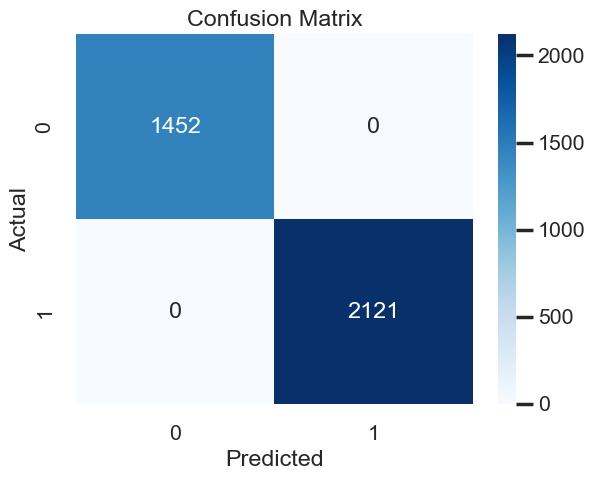

In [109]:
# Confusion Matrix
cm = confusion_matrix(y_test, final_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

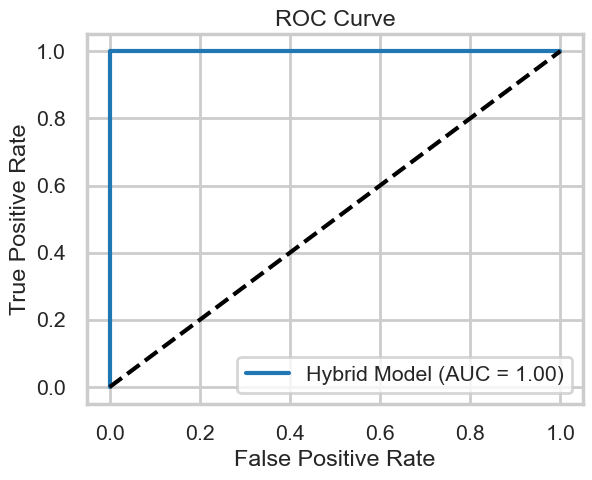

In [110]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, final_probs[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Hybrid Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

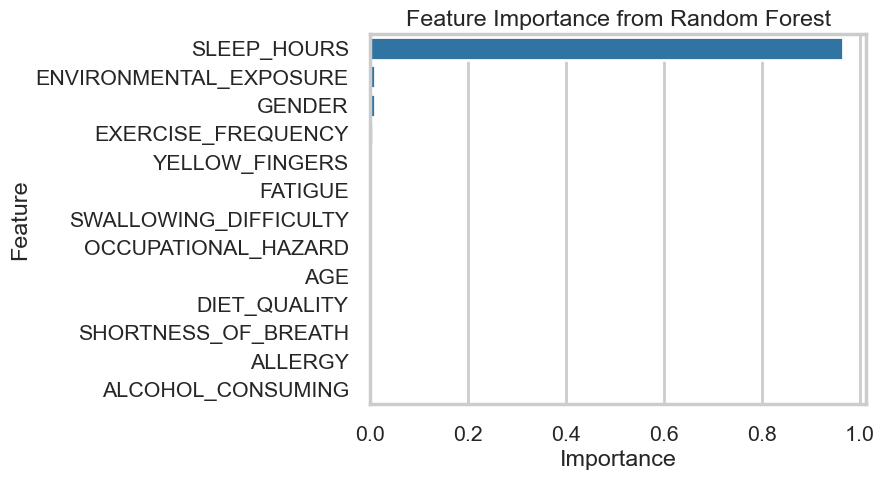

In [111]:
# Feature Importance
rf_importances = rf.feature_importances_
feature_names = [X.columns[i] for i in best_features]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

Generation 0: Best Fitness = 0.915061224489796
Generation 1: Best Fitness = 0.915061224489796
Generation 2: Best Fitness = 0.915061224489796
Generation 3: Best Fitness = 0.915061224489796
Generation 4: Best Fitness = 0.915061224489796
Generation 5: Best Fitness = 0.915061224489796
Generation 6: Best Fitness = 0.919061224489796
Generation 7: Best Fitness = 0.919061224489796
Generation 8: Best Fitness = 0.919061224489796
Generation 9: Best Fitness = 0.919061224489796
Generation 10: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 11: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 12: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 13: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 14: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 15: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 16: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 17: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 18: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 19: Best Fitness = 0.919061224489796
Generation 20: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 21: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 22: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 23: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 24: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 25: Best Fitness = 0.919061224489796


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 26: Best Fitness = 0.919061224489796
Generation 27: Best Fitness = 0.9191020408163265
Generation 28: Best Fitness = 0.9191020408163265
Generation 29: Best Fitness = 0.9191020408163265
Generation 30: Best Fitness = 0.9191020408163265
Generation 31: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 32: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 33: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 34: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 35: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 36: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 37: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 38: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 39: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 40: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 41: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 42: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 43: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 44: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 45: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 46: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 47: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 48: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 49: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 50: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 51: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 52: Best Fitness = 0.9191020408163265
Generation 53: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 54: Best Fitness = 0.9191020408163265
Generation 55: Best Fitness = 0.9191020408163265
Generation 56: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 57: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 58: Best Fitness = 0.9191020408163265
Generation 59: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 60: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 61: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 62: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 63: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 64: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 65: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 66: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 67: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 68: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 69: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 70: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 71: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 72: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 73: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 74: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 75: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 76: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 77: Best Fitness = 0.9191020408163265
Generation 78: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 79: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 80: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 81: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 82: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 83: Best Fitness = 0.9191020408163265
Generation 84: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 85: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 86: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 87: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 88: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 89: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 90: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 91: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 92: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 93: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 94: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 95: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 96: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 97: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 98: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 99: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 100: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 101: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 102: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 103: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 104: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 105: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 106: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 107: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 108: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 109: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 110: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 111: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 112: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 113: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 114: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 115: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 116: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 117: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 118: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 119: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 120: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 121: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 122: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 123: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 124: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 125: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 126: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 127: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 128: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 129: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 130: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 131: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 132: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 133: Best Fitness = 0.9191020408163265
Generation 134: Best Fitness = 0.9191020408163265
Generation 135: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 136: Best Fitness = 0.9191020408163265
Generation 137: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 138: Best Fitness = 0.9191020408163265
Generation 139: Best Fitness = 0.9191020408163265
Generation 140: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 141: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 142: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 143: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 144: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 145: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 146: Best Fitness = 0.9191020408163265
Generation 147: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 148: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 149: Best Fitness = 0.9191020408163265
Generation 150: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 151: Best Fitness = 0.9191020408163265
Generation 152: Best Fitness = 0.9191020408163265
Generation 153: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 154: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 155: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 156: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 157: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 158: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 159: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 160: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 161: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 162: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 163: Best Fitness = 0.9191020408163265
Generation 164: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 165: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 166: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 167: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 168: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 169: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 170: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 171: Best Fitness = 0.9191020408163265
Generation 172: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 173: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 174: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 175: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 176: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 177: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 178: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 179: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 180: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 181: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 182: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 183: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 184: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 185: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 186: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 187: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 188: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 189: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 190: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 191: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 192: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 193: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 194: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 195: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 196: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 197: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 198: Best Fitness = 0.9191020408163265


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Generation 199: Best Fitness = 0.9191020408163265


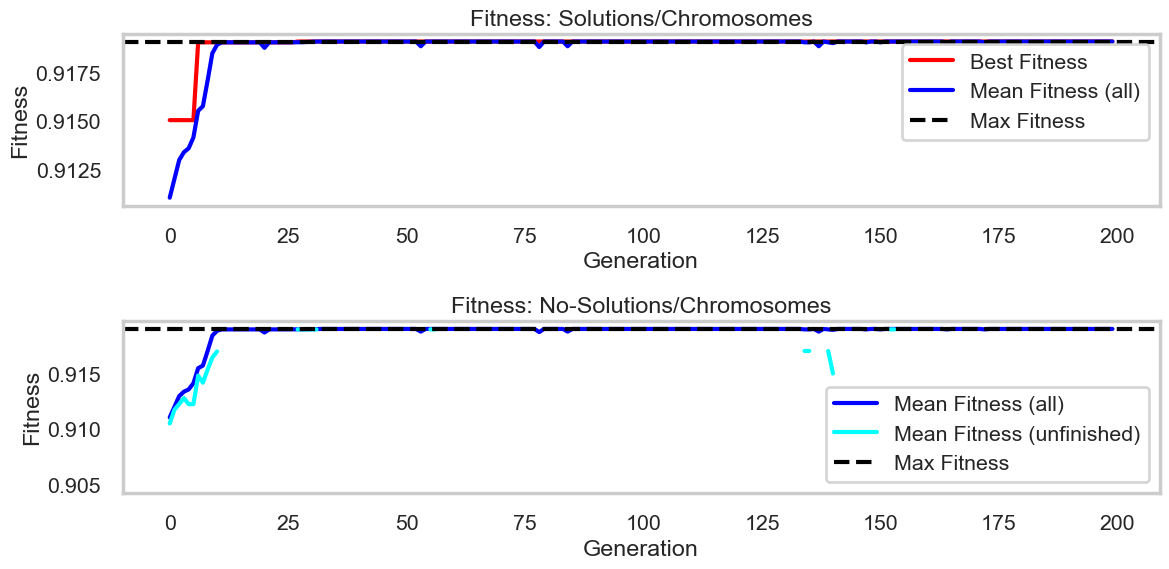

In [112]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# GA Setup
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define hyperparameter ranges
MAX_DEPTH_MIN, MAX_DEPTH_MAX = 1, 50
N_ESTIMATORS_MIN, N_ESTIMATORS_MAX = 10, 200
LEARNING_RATE_MIN, LEARNING_RATE_MAX = 0.01, 0.5

def random_hybrid_params():
    return [
        random.randint(MAX_DEPTH_MIN, MAX_DEPTH_MAX),  # max_depth for RF
        random.randint(N_ESTIMATORS_MIN, N_ESTIMATORS_MAX),  # n_estimators for RF
        random.uniform(LEARNING_RATE_MIN, LEARNING_RATE_MAX)  # learning_rate for XGB
    ]

toolbox.register("individual", tools.initIterate, creator.Individual, random_hybrid_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def evaluate_hybrid(individual):
    max_depth_rf = int(np.clip(individual[0], MAX_DEPTH_MIN, MAX_DEPTH_MAX))
    n_estimators_rf = int(np.clip(individual[1], N_ESTIMATORS_MIN, N_ESTIMATORS_MAX))
    learning_rate_xgb = np.clip(individual[2], LEARNING_RATE_MIN, LEARNING_RATE_MAX)

    # Random Forest Classifier
    rf = RandomForestClassifier(
        max_depth=max_depth_rf,
        n_estimators=n_estimators_rf,
        random_state=42
    )
    
    # XGBoost Classifier
    xgb = XGBClassifier(
        learning_rate=learning_rate_xgb,
        random_state=42
    )
    
    # Cross-validation
    skf = StratifiedKFold(n_splits=5)
    rf_scores = cross_val_score(rf, X_train, y_train, cv=skf, scoring='accuracy')
    xgb_scores = cross_val_score(xgb, X_train, y_train, cv=skf, scoring='accuracy')
    
    # Combined fitness as the average of both models
    return (np.mean(rf_scores) + np.mean(xgb_scores)) / 2,

toolbox.register("evaluate", evaluate_hybrid)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA Execution
population = toolbox.population(n=50)
ngen = 200  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

# Track fitness
best_fitness = []
mean_fitness = []
unfinished_fitness = []

for generation in range(ngen):
    # Apply crossover and mutation
    offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)
    
    # Evaluate fitness of offspring
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    
    # Select the next generation
    population = toolbox.select(offspring, len(population))
    
    # Track statistics
    fits = [ind.fitness.values[0] for ind in population]
    best_fitness.append(max(fits))
    mean_fitness.append(np.mean(fits))
    unfinished_fitness.append(np.mean([fit for fit in fits if fit < max(fits)]))

    print(f"Generation {generation}: Best Fitness = {best_fitness[-1]}")

# Visualization
plt.figure(figsize=(12, 6))

# First plot: Fitness of solutions
plt.subplot(2, 1, 1)
plt.plot(best_fitness, label="Best Fitness", color='red')
plt.plot(mean_fitness, label="Mean Fitness (all)", color='blue')
plt.axhline(y=max(best_fitness), color='black', linestyle='--', label="Max Fitness")
plt.title("Fitness: Solutions/Chromosomes")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid()

# Second plot: Fitness of no-solution chromosomes
plt.subplot(2, 1, 2)
plt.plot(mean_fitness, label="Mean Fitness (all)", color='blue')
plt.plot(unfinished_fitness, label="Mean Fitness (unfinished)", color='cyan')
plt.axhline(y=max(best_fitness), color='black', linestyle='--', label="Max Fitness")
plt.title("Fitness: No-Solutions/Chromosomes")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Random Forest hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# GridSearchCV setup
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Perform Grid Search
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Best model evaluation
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Test Set Accuracy:", accuracy)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total ti

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [114]:
import random
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define hyperparameter ranges for RF + XGBoost
RF_PARAMS = {
    'n_estimators': (10, 200),
    'max_depth': (3, 30)
}

XGB_PARAMS = {
    'learning_rate': (0.01, 0.5),
    'n_estimators': (10, 200),
    'max_depth': (3, 30)
}

def random_hybrid_params():
    rf_n_estimators = random.randint(*RF_PARAMS['n_estimators'])
    rf_max_depth = random.randint(*RF_PARAMS['max_depth'])
    xgb_learning_rate = random.uniform(*XGB_PARAMS['learning_rate'])
    xgb_n_estimators = random.randint(*XGB_PARAMS['n_estimators'])
    xgb_max_depth = random.randint(*XGB_PARAMS['max_depth'])
    return [rf_n_estimators, rf_max_depth, xgb_learning_rate, xgb_n_estimators, xgb_max_depth]

# Setup Genetic Algorithm (DEAP)
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, random_hybrid_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function for the hybrid model
def evaluate_hybrid(individual):
    rf_n_estimators, rf_max_depth, xgb_learning_rate, xgb_n_estimators, xgb_max_depth = individual

    # Define models
    rf = RandomForestClassifier(n_estimators=int(rf_n_estimators), max_depth=int(rf_max_depth), random_state=42)
    xgb = XGBClassifier(learning_rate=xgb_learning_rate, n_estimators=int(xgb_n_estimators), max_depth=int(xgb_max_depth), use_label_encoder=False, eval_metric='logloss', random_state=42)

    # Combine models with voting
    hybrid_model = VotingClassifier(estimators=[('rf', rf), ('xgb', xgb)], voting='soft')

    # Evaluate using cross-validation
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(hybrid_model, X_train, y_train, cv=skf, scoring='accuracy')
    return np.mean(scores),

toolbox.register("evaluate", evaluate_hybrid)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Function to tune GA parameters
def tune_ga_params(population_sizes, cxpbs, mutpbs, ngens):
    best_results = []
    for pop_size in population_sizes:
        for cxpb in cxpbs:
            for mutpb in mutpbs:
                for ngen in ngens:
                    print(f"Tuning GA Params - pop_size: {pop_size}, cxpb: {cxpb}, mutpb: {mutpb}, ngen: {ngen}")
                    
                    # GA execution
                    population = toolbox.population(n=pop_size)
                    best_fitness = []
                    
                    for generation in range(ngen):
                        offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)
                        fits = toolbox.map(toolbox.evaluate, offspring)

                        for fit, ind in zip(fits, offspring):
                            ind.fitness.values = fit

                        population = toolbox.select(offspring, len(population))

                        fits = [ind.fitness.values[0] for ind in population]
                        best_fitness.append(max(fits))

                    # Get best individual
                    best_individual = tools.selBest(population, k=1)[0]
                    best_results.append({
                        'pop_size': pop_size,
                        'cxpb': cxpb,
                        'mutpb': mutpb,
                        'ngen': ngen,
                        'best_fitness': max(best_fitness),
                        'best_params': best_individual
                    })

    # Sort results by best fitness
    best_results = sorted(best_results, key=lambda x: x['best_fitness'], reverse=True)
    return best_results

# Define ranges for GA tuning
population_sizes = [20, 50]
cxpbs = [0.5, 0.7]
mutpbs = [0.2, 0.4]
ngens = [50, 100]

# Run tuning
results = tune_ga_params(population_sizes, cxpbs, mutpbs, ngens)

# Print best configuration
print("Best GA Configuration:")
print(results[0])


Tuning GA Params - pop_size: 20, cxpb: 0.5, mutpb: 0.2, ngen: 50


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py", line 66, in inner_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_voting.py", line 423, in fit
    return super().fit(X, transformed_y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_voting.py", line 104, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/parallel.py", line 136, in __call__
    return self.function(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/ensemble/_base.py", line 40, in _fit_single_estimator
    estimator.fit(X, y, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/_param_validation.py", line 95, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'n_estimators' parameter of RandomForestClassifier must be an int in the range [1, inf). Got -23 instead.


In [115]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define base models
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Create a VotingClassifier
hybrid_model = VotingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    voting='soft'
)

# Define parameter grid
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [10, 20, 30],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [3, 6, 9]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(
    estimator=hybrid_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=StratifiedKFold(n_splits=5),
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:01] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xg

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.01, xg

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:02] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xg

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:03] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_ra

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:04] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:05] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:06] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:07] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:08] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   1.0s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.9s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   1.0s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   1.0s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   1.0s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   1.0s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   1.0s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.8s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=10, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:12] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.1s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:13] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_ra

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:14] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.1, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:15] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_ra

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_r

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_r

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:18] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.7s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:20] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=20, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.01

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:21] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__ma

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.1, xgb_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__m

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.2s
[CV] END rf__max_depth=30, rf__n_estimators=50, xgb__learning_rate=0.2, xgb_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:23] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_ra

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:24] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.3s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:26] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=100, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rat

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:27] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_ra

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.01, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1,

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.1, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=50; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=100; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.7s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=3, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, x

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.6s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=6, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=50; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src

[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=100; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.5s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0.2, xgb__max_depth=9, xgb__n_estimators=150; total time=   0.4s
[CV] END rf__max_depth=30, rf__n_estimators=150, xgb__learning_rate=0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:31:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  war

Best Parameters: {'rf__max_depth': 10, 'rf__n_estimators': 50, 'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 150}
Best Score: 0.9231020408163264
Test Accuracy: 0.8548387096774194


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:33:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:33:26] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 0: Best Fitness = 0.9231


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:34:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:34:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:34:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:34:34] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 1: Best Fitness = 0.9231


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:35:43] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 2: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:36:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:36:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:36:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:36:52] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 3: Best Fitness = 0.9231


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:38:06] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 4: Best Fitness = 0.9231


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:39:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:39:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:39:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:39:25] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 5: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:40:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:40:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 6: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:42:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:42:11] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 7: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:43:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:43:30] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 8: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:44:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:44:50] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 9: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:46:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:46:21] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 10: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:47:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:47:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:47:43] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 11: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:49:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:49:03] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 12: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:50:24] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 13: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:51:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:51:47] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 14: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:53:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:53:12] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 15: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:54:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:54:37] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 16: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:55:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 17: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:57:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:57:18] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 18: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:58:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [02:58:39] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 19: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:00:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:00:01] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 20: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:01:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:01:25] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 21: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:02:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:02:50] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 22: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:04:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:04:14] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 23: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:05:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:05:37] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 24: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:06:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:06:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:07:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:07:00] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 25: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:08:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:08:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:08:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:08:22] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 26: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:09:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:09:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:09:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:09:44] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 27: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:11:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:11:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:11:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:11:08] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 28: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:12:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:12:31] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 29: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:13:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:13:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:13:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:13:50] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 30: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:15:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:15:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:15:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:15:07] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 31: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:16:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:16:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:16:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:16:25] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 32: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:17:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:17:41] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 33: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:18:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:18:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:18:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:18:58] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 34: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:20:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:20:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:20:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:20:14] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 35: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:21:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:21:32] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 36: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:22:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:22:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:22:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:22:50] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 37: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:24:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:24:08] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 38: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:25:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:25:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:25:25] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 39: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:26:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:26:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:26:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:26:42] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 40: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:27:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:27:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:27:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:27:58] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 41: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:29:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:29:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:29:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:29:14] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 42: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:30:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:30:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:30:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:30:27] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 43: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:31:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:31:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:31:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:31:39] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 44: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:32:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:32:53] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 45: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:34:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:34:06] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 46: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:35:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:35:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:35:18] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 47: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:36:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:36:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:36:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:36:30] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 48: Best Fitness = 0.9271


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:37:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:37:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:37:42] WARNING: /Users/runner/work/xgboost/xgboost/src

Generation 49: Best Fitness = 0.9271


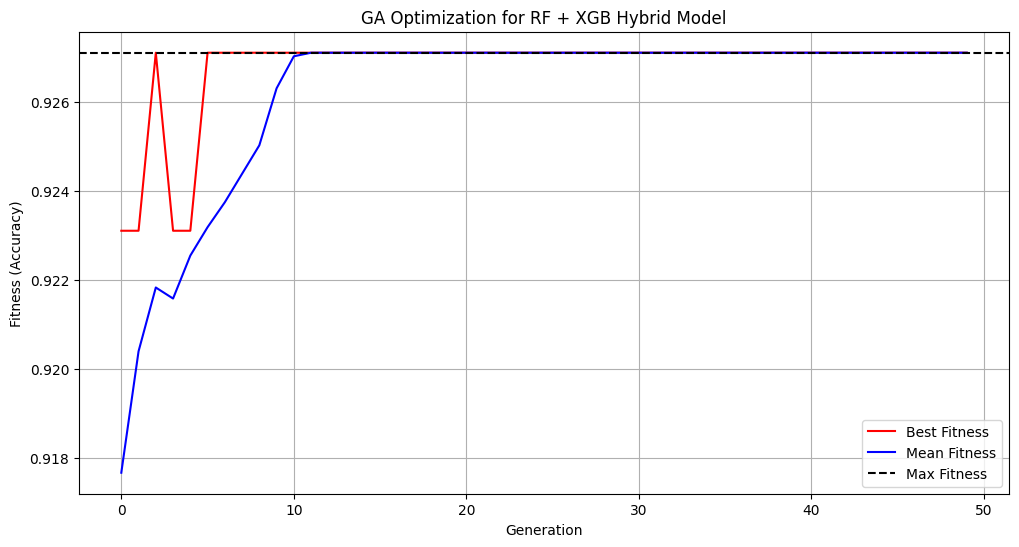


Best Parameters from GA:
RF n_estimators: 100
RF max_depth: 23
XGB learning_rate: 0.0266
XGB n_estimators: 138
XGB max_depth: 2

Test Accuracy: 0.8710


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [03:38:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [2]:
import random
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np

# Load dataset
data = pd.read_csv("lung_cancer.csv")

# Preprocessing
X = data.drop(columns=['LUNG_CANCER'])
y = data['LUNG_CANCER']

# Encode categorical variables
label_encoder = LabelEncoder()
X['GENDER'] = label_encoder.fit_transform(X['GENDER'])
y = label_encoder.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# GA Setup
if "FitnessMax" not in creator.__dict__:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if "Individual" not in creator.__dict__:
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

# Define hyperparameter ranges
RF_N_ESTIMATORS_MIN, RF_N_ESTIMATORS_MAX = 50, 150
RF_MAX_DEPTH_MIN, RF_MAX_DEPTH_MAX = 5, 30
XGB_LEARNING_RATE_MIN, XGB_LEARNING_RATE_MAX = 0.01, 0.3
XGB_N_ESTIMATORS_MIN, XGB_N_ESTIMATORS_MAX = 50, 150
XGB_MAX_DEPTH_MIN, XGB_MAX_DEPTH_MAX = 3, 10

def random_hybrid_params():
    return [
        random.randint(RF_N_ESTIMATORS_MIN, RF_N_ESTIMATORS_MAX),  # RF n_estimators
        random.randint(RF_MAX_DEPTH_MIN, RF_MAX_DEPTH_MAX),  # RF max_depth
        random.uniform(XGB_LEARNING_RATE_MIN, XGB_LEARNING_RATE_MAX),  # XGB learning_rate
        random.randint(XGB_N_ESTIMATORS_MIN, XGB_N_ESTIMATORS_MAX),  # XGB n_estimators
        random.randint(XGB_MAX_DEPTH_MIN, XGB_MAX_DEPTH_MAX)  # XGB max_depth
    ]

toolbox.register("individual", tools.initIterate, creator.Individual, random_hybrid_params)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Evaluation function
def evaluate_hybrid(individual):
    rf_n_estimators = int(np.clip(individual[0], RF_N_ESTIMATORS_MIN, RF_N_ESTIMATORS_MAX))
    rf_max_depth = int(np.clip(individual[1], RF_MAX_DEPTH_MIN, RF_MAX_DEPTH_MAX))
    xgb_learning_rate = np.clip(individual[2], XGB_LEARNING_RATE_MIN, XGB_LEARNING_RATE_MAX)
    xgb_n_estimators = int(np.clip(individual[3], XGB_N_ESTIMATORS_MIN, XGB_N_ESTIMATORS_MAX))
    xgb_max_depth = int(np.clip(individual[4], XGB_MAX_DEPTH_MIN, XGB_MAX_DEPTH_MAX))

    # Random Forest Classifier
    rf = RandomForestClassifier(
        n_estimators=rf_n_estimators,
        max_depth=rf_max_depth,
        random_state=42
    )

    # XGBoost Classifier
    xgb = XGBClassifier(
        learning_rate=xgb_learning_rate,
        n_estimators=xgb_n_estimators,
        max_depth=xgb_max_depth,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # Evaluate using cross-validation
    hybrid_model = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb)],
        voting='soft'
    )
    skf = StratifiedKFold(n_splits=5)
    scores = cross_val_score(hybrid_model, X_train, y_train, cv=skf, scoring='accuracy')

    return np.mean(scores),

toolbox.register("evaluate", evaluate_hybrid)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# GA Execution
population = toolbox.population(n=50)
ngen = 50  # Number of generations
cxpb = 0.5  # Crossover probability
mutpb = 0.2  # Mutation probability

# Track fitness
best_fitness = []
mean_fitness = []

for generation in range(ngen):
    # Apply crossover and mutation
    offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)

    # Evaluate fitness of offspring
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    # Select the next generation
    population = toolbox.select(offspring, len(population))

    # Track statistics
    fits = [ind.fitness.values[0] for ind in population]
    best_fitness.append(max(fits))
    mean_fitness.append(np.mean(fits))

    print(f"Generation {generation}: Best Fitness = {best_fitness[-1]:.4f}")

# Visualization
plt.figure(figsize=(12, 6))
plt.plot(best_fitness, label="Best Fitness", color='red')
plt.plot(mean_fitness, label="Mean Fitness", color='blue')
plt.axhline(y=max(best_fitness), color='black', linestyle='--', label="Max Fitness")
plt.title("GA Optimization for RF + XGB Hybrid Model")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.legend()
plt.grid()
plt.show()

# Best individual
best_individual = tools.selBest(population, k=1)[0]
best_rf_n_estimators, best_rf_max_depth, best_xgb_learning_rate, best_xgb_n_estimators, best_xgb_max_depth = best_individual

print("\nBest Parameters from GA:")
print(f"RF n_estimators: {int(best_rf_n_estimators)}")
print(f"RF max_depth: {int(best_rf_max_depth)}")
print(f"XGB learning_rate: {best_xgb_learning_rate:.4f}")
print(f"XGB n_estimators: {int(best_xgb_n_estimators)}")
print(f"XGB max_depth: {int(best_xgb_max_depth)}")

# Final Model Training
rf_final = RandomForestClassifier(
    n_estimators=int(best_rf_n_estimators),
    max_depth=int(best_rf_max_depth),
    random_state=42
)
xgb_final = XGBClassifier(
    learning_rate=best_xgb_learning_rate,
    n_estimators=int(best_xgb_n_estimators),
    max_depth=int(best_xgb_max_depth),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
hybrid_final = VotingClassifier(
    estimators=[('rf', rf_final), ('xgb', xgb_final)],
    voting='soft'
)
hybrid_final.fit(X_train, y_train)

# Test set evaluation
y_pred = hybrid_final.predict(X_test)
test_accuracy = np.mean(y_pred == y_test)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


DEPLOYMENT

In [3]:
import joblib

In [5]:
joblib.dump(hybrid_final, 'hybrid_model.pkl')

['hybrid_model.pkl']

In [6]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [11]:
# Example input data (replace with actual feature values)
new_data = [[45, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]]  # Example features for one prediction

# Transform the input data using the saved scaler
new_data_scaled = scaler.transform(new_data)

# Make prediction using the saved model
prediction_numeric = model.predict(new_data_scaled)

# Convert the numeric prediction back to the original labels (e.g., "YES" or "NO")
prediction_label = label_encoder.inverse_transform(prediction_numeric)

print(f"Prediction: {prediction_label[0]}")  # Output the label, e.g., "YES" or "NO"


Prediction: NO


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [18]:
import joblib

# Example saving
joblib.dump(model, 'hybrid_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [ ]:
from flask import Flask, request, jsonify
import joblib
import numpy as np

# Load saved model and other assets
model = joblib.load('hybrid_model.pkl')  # Replace with your model filename
scaler = joblib.load('scaler.pkl')       # Replace with your scaler filename
label_encoder = joblib.load('label_encoder.pkl')  # Replace with your label encoder filename

# Initialize Flask app
app = Flask(__name__)

@app.route('/')
def home():
    return "Lung Cancer Prediction API is running!"

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from the POST request
        data = request.get_json()

        # Validate input
        if 'features' not in data:
            return jsonify({'error': 'Missing "features" in request data'}), 400

        # Extract features and reshape for model
        features = np.array(data['features']).reshape(1, -1)

        # Scale features using the loaded scaler
        scaled_features = scaler.transform(features)

        # Make prediction using the loaded model
        prediction_numeric = model.predict(scaled_features)

        # Convert numeric prediction to label
        prediction_label = label_encoder.inverse_transform(prediction_numeric)

        # Return prediction as JSON
        return jsonify({'prediction': prediction_label[0]})
    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=True)


ModuleNotFoundError: No module named 'flask'